# Prédiction l'évolution du cours du Bitcoin

Nous y voilà : vous allez devoir travailler maintenant pour proposer votre propre algorithme de descente pour résoudre un problème de classification tout simple. Je vous donne l'historique sur 2020 et 2021 du cours du Bitcoin et vous devez construire un prédicteur capable de détecter si le cours du Bitcoin va partir à la hausse ou à la baisse. 

Vous serez évaluez sur la qualité du travail réalisé et surtout sur les résultats que vous obtiendrez sur des données que vous ne connaissez pas. En fonction de vos résultats par rapport aux autres binômes vous obtiendrez plus ou moins de points. 

Voyons un peu plus les choses en détails.

## Définition du sujet

### Le cours du Bitcoin

Dans les fichiers Cotations2021.csv et Cotations2020.csv vous trouverez l'évolution journalière du cours du Bitcoin en 2021 et en 2020. Ces fichiers contiennent 5 colonnes : 
 - Date : jour de la cotation,
 - Ouverture : valeur en euros du cours du Bitcoin à l'ouverture du marché,
 - Plus Haut : valeur en euros la plus élevée du Bitcoin durant le jour considéré,
 - Plus Bas : valeur en euros la plus basse du Bitcoin durant le jour considéré,
 - Clôture : valeur en euros du cours du Bitcoin à la clôture du marché.

La notion de "cours du Bitcoin" est assez vague : finalement, on se pose vraiment la question de savoir combien vaut le Bitcoin au moment où on doit en acheter ou en vendre... Pour simplifier un peu, nous considérerons que d'un jour $t$ à un jour $(t+1)$ le cours du Bitcoin augmente (diminue) si sa valeur à la clôture au jour $t$ est inférieure (supérieure) à sa valeur à la clôture au jour $(t+1)$. 

Autrement dit, on va regarder la colonne "Clôture" pour décider de l'augmentation ou la baisse du cours du Bitcoin. 

### Enoncé du problème de classification

Le problème que vous avez à résoudre est donc un problème de classification : pour un jour $t$ donné, vous voulez prédire si à $(t+1)$ le cours va augmenter (classe 1) ou diminuer (classe 2). Le cas, marginal, ou le cours reste constant sera assimilé à la classe 2.

Pour réaliser cette prédiction, vous pouvez prendre en compte l'historique du cours sur les $h$ derniers jours. Vous aurez toute liberté de définir cette notion d'historique : c'est d'ailleurs un des facteurs qui pourra influencer la qualité de votre prédicteur. Quelle valeur de $h$ considérer ? Quelle(s) donnée(s) considérer sur les jours précédents : uniquement la valeur de clôture ou ... ? 

### Démarche pour réaliser ce travail

Déjà, vous pouvez fortement vous inspirer de ce que l'on a fait dans la première partie des Travaux Pratiques, ainsi que sur le cours (notamment, le chapitre "Liens avec le Machine Learning", partie sur l'exemple de la société ERAM). 

Au niveau démarche, c'est toujours la même chose : 
1. Définir la notion d'historique : quel vecteur de données allez vous prendre en compte pour l'apprentissage et la prédiction ensuite ? Notons $\vec v$ ce vecteur.
1. Définir le problème d'optimisation à résoudre (fonction $H(\vec v)$ de séparation des données, fonction d'activation (sigmoide), fonction de perte/erreur),
2. Définir le gradient,
3. Créer votre algorithme de descente,

Pour ce dernier point, vous pourrez faire appel à toutes les techniques/éléments vus dans le chapitre "Optimisation continue sans contraintes" quand nous avons parlé des algorithmes de descente.

En plus du code Python ci-dessus, il faudra produire du code de traitement des données et du code pour que je puisse mettre en oeuvre l'évaluation de votre projet.

## Développement de votre algorithme de descente

### Outils conseillés
- La bibliothèque [pandas](https://pandas.pydata.org/docs/user_guide/index.html) est idéale pour l'utilisation d'une base de donnée.
- La bibliothèque [numpy](https://numpy.org/doc/1.18/user/index.html) est parfaite pour tout calcul sur des vecteurs.
- La bibliothèque [matplotlib](https://matplotlib.org/contents.html) est la base pour visualiser des résultats mais accouplé à [seaborn](https://seaborn.pydata.org/index.html) il est possible d'aller plus vite.
- Le bibliothèque [math](https://docs.python.org/fr/3.9/library/math.html) est souvent oubliée tellement elle semble évidente.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import random as rd
import os

### Lecture des données

La première tâche à réaliser va être de développer une fonction qui va lire un fichhier .csv contenant un historique de cotations et créer une base panda. La structure $RawData$ va contenir les données telles que contenues dans le fichier .csv passé en paramètre (selon la syntaxe décrite précédemment). De même, $RawC$ va contenir l'appartenance aux classes 1 (diminution) / 0 (augmentation).

Vous utiliserez les structures $RawData$ et $RawC$ comme vous le souhaiterez par la suite dans vos algorithmes : par contre, ces structures sont à considérer comme des données d'entrée dans toute la suite des TPs.

Autrement dit, pour évaluer vos algorithmes je serais amené à leur donner de nouveaux $RawData$ et $RawC$ contenant des données que vous ne connaissez pas. 

In [4]:
#Input: nom du fichier .csv à lire.
#Nécessite :les lignes du fichier sont classées par dates de cotatation croissantes et les colonnées séparées par ";"
#Output: RawData, contient l'historique des cotations telles que lues dans le .csv
#        RawC, contient pour chaque ligne/date t (sauf la dernière) 1 si le cours baisse à t+1; 0 sinon.
def LireDonnees(NomFichier):
    #Lecture des données dans le fichier csv
    RawData=pd.read_csv(NomFichier, sep=';')
    
    #Construction des classes d'appartenance de chaque ligne de la base: on suppose que les cotations journalières sont
    #classées par ordre chronologique
    RawC=[]
    for index in range(len(RawData)-1):
        value=RawData.iloc[index,4] > RawData.iloc[index+1,4]
        value=1*value
        RawC.append(value)
    return RawData, RawC


    

### Définition des données utilisées pour l'apprentissage/prédiction

Nous allons maintenant définir une méthode qui va préparer une structure de données, nommée $data$, qui va contenir pour chaque ligne un couple :

$\vec v=(\vec x ; c_x)$

où $\vec x$ est le vecteur caractérisant la ligne en cours. Prenons un exemple, que vous adapterez comme vous le souhaitez par la suite. Je décide que pour la ligne $t$, date de cotation $t$, ce qui explique la prédiction $c$ (baisse/augmentation de la valeur de la cotation à $t+1$) c'est le cours du Bitcoin à la clôture sur les $h=3$ derniers jours. Donc, la ligne d'indice 0 dans $D$ va contenir :

$(x_1,x_2,x_3,)$

avec $x_j$ la valeur de cotation à la clôture le jour $j$, et $C$ va contenir : 0 ou 1 selon la variation avec le jour $t+1$.

Créez la fonction CreerData ci-dessous pour avoir par la suite des données plus faciles à manipuler grâce à numpy.

In [16]:
#Input: RawData et RawC ont été créés à partir d'un fichier .csv
#        SizeVector, la taille des vecteurs de données à créer
#Output: D, contient les points $(\vec x)$. Cela doit être une matrice numpy
#        C, contient la classe d'appartenance $c_x$ de chaque entrée dans data. Cela doit être un vecteur numpy
def CreerData(RawData,RawC,SizeVector,normalize=False):
    print("RawData size :", len(RawData))
    print("RawC size :", len(RawC))
    sizeData=len(RawC)-SizeVector
    D = np.zeros((sizeData,SizeVector+1))
    C = np.zeros((sizeData))
    for index in range(sizeData):
        C[index]=RawC[index+SizeVector]
        biggestValue = 0
        for i in range(SizeVector):
            D[index,i]=RawData.iloc[index+i,4]
            if normalize:
                biggestValue = max(abs(D[index,i]), biggestValue)
            
        if normalize:
            for i in range(SizeVector):
                D[index,i] = D[index,i]/biggestValue
        D[index,SizeVector]=1  # Ajout du biais dans les données
        
    return(D,C)



### Définition du problème d'optimisation à résoudre

<<Expliquer ici le problème d'optimisation que vous voulez résoudre>>

Commençons par définir le code qui calcule $H(\vec v)$ puis le code de la fonction logistique sigmoid $\cal{S}(x)$. Je suppose que vous allez reprendre les mêmes fonctions que dans le TP introductif, mais si vous voulez changer vous pouvez, bien sûr ! 

In [6]:
# définition de la méthode pour calculer H(v)
def H(weights, point):
    value=np.sum(weights*point)
    return value

Définissons maintenant le code qui calcule $\mathcal{S}(x)$.

In [7]:
# définition des fonctions d'activation
def Sigmoid(x, lamda=0.1):
        return 1/(1+np.exp(-lamda*x))

def Step_function(x):
        return 1*(x>=0)

def ReLU(x):
        return np.maximum(0,x)

def leaky_ReLU(x, alpha=0.01):
        return np.maximum(alpha*x,x)

def SiLU(x):
        return x*Sigmoid(x)

def GELU(x):
        return 0.5*x*(1+np.tanh(np.sqrt(2/np.pi)*(x+0.044715*x**3)))

def ELU(x, alpha=1.0):
        return np.where(x>=0, x, alpha*(np.exp(x)-1))


#dérivée des fonctions d'activation
def d_Sigmoid(x, lamda=0.1):
        sig=Sigmoid(x, lamda)
        return lamda*sig*(1-sig)

def d_leaky_ReLU(x, alpha=0.01):
        return 1*(x>=0) + alpha*(x<0)

def d_SiLU(x, lamda=0.1):
        sig=Sigmoid(x, lamda)
        return sig + x*lamda*sig*(1-sig)

def d_GELU(x):
        tanh_term = np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3))
        sech2_term = 1 - tanh_term**2
        return 0.5 * (1 + tanh_term) + (0.5 * x * sech2_term * np.sqrt(2/np.pi) * (1 + 3 * 0.044715 * x**2))

def d_ELU(x, alpha=1.0):
        return 1*(x>=0) + alpha * np.exp(x)*(x<0)




Passons maintenant à la définition de la fonction d'erreur $E(\mathcal{P})$, qui est notre fonction à minimiser, ainsi que du gradient. Je vous laisse les définir !

In [8]:
# définition de la méthode pour calculer l'erreur 
#Input : weights, le vecteur de poids utilisés dans la fonction H,
#        D, la matrice des données
#        C, le vecteur des classes d'appartenance
#Output : une valeur numérique, l'erreur commise. 
def Loss_function(D,C,weights,func=Sigmoid):
    loss_value = 0
    for index in range(len(D)):
        p = D[index:index+1,:]
        c = C[index]
        loss_value -= c*np.log2(func(H(weights, p)))+(1-c)*np.log2(1-func(H(weights, p)))
    return loss_value

def loss_function_mean_squared(D,C,weights,func=Sigmoid):
	loss_value = 0
	for index in range(len(D)):
		p = D[index:index+1,:]
		c = C[index]
		prediction = func(H(weights, p))
		loss_value += (c - prediction)**2
	return loss_value / len(D)

In [9]:
# définition du calcul de gradient
#Input : weights, le vecteur de poids utilisés dans la fonction H,
#        D, la matrice des données : doit contenir au moins un vecteur
#        C, le vecteur des classes d'appartenance
#		 func, fonction d'activation utilisée
#Output : le gradient, un numpy array
def Gradient(D,C,weights, func):
    grad = np.zeros(len(weights))
    # Looping over all variables (number of variables=number of weights)
    for indexW in range(len(weights)-1):
        coord_value=0
        for indexD in range(len(D)):
            x=D[indexD:indexD+1,:]
            coord_value-= x[0,indexW]*(C[indexD]-func(H(weights, x)))
        grad[indexW] = coord_value
    coord_value=0
    # Considering the last component=bias
    for indexD in range(len(D)):
        x=D[indexD:indexD+1,:]
        coord_value-= (C[indexD]-func(H(weights, x)))
    grad[-1] = coord_value
    
    return np.array(grad)

### Algorithme de descente

<<Expliquer ici quels sont les caractéristiques/paramètres de votre algorithme de descente>>

<<Justifiez les choix retenus et les choix testés>>

Note: lorsque vous coderez votre algorithme de gradient, il faut que celui-ci affiche dans un graphique l'évolution de la valeur de la fonction d'erreur/loss et l'évolution de la norme du gradient.


In [10]:
# Votre algorithme de gradient qui va travailler à partir des structures numpy D et C
# Input : D, la matrice des données
#         C, le vecteur des classes d'appartenance
#         sizeVector, la taille des vecteurs de données
#         func, la fonction d'activation utilisée (par défaut Sigmoid)
#         maxstep, le nombre maximum d'itérations (par défaut 1000)
#         tol, la tolérance pour le critère d'arrêt (par défaut 1e
#         learning_rate, le taux d'apprentissage (par défaut 0.001)
# 	      shouldplot, booléen indiquant s'il faut afficher la convergence ou pas
# Nécessite :
# Output : weights, un numpy array contenant les poids utilisés dans la fonction de séparation H 
#          bias, un numérique contenant la constante utilisée dans la fonction de séparation H
#          nbstep, nombre d'itérations mises par l'algorithme avant de s'arrêter

# ATTENTION: j'ai laissé dans l'algorithme vide ci-dessous des lignes de code permettant l'affichage de la fonction de perte/loss
#            et la norme du gradient. Gardez ce code qui vous aidera à voir si votre algorithme converge ou pas.

def Algorithme_Gradient(D,C,sizeVector, func=Sigmoid, maxstep=1000, tol=1e-6, learning_rate=0.001,shouldplot=False,weights=None):
	#Initialisations pour les graphiques terminaux: à conserver
	## Pour visualiser les evolutions en fonction du step
	itersteps = []
	### Pour visualiser l'evolution de la norme du gradient
	iterGap = []
	### Pour visualiser l'évolution de l'erreur
	iterError = []
	### Pour visualiser l'évolution de dw
	iterDw = []
	
	#Initialisation des poids et du biais
	if weights is None:
		weights = np.random.rand(sizeVector+1)
	nbstep=0
	
	for step in range(maxstep):
		nbstep+=1
		grad=Gradient(D,C,weights,func)
		normGrad=np.linalg.norm(grad)
		grad=grad/normGrad
		
		dw = learning_rate * grad[:]
		# Mise à jour des poids et du biais
		weights -= dw
		print(dw)
		
		# Calcul de l'erreur
		error = Loss_function(D,C,weights)
		
		
		
		# Stockage des valeurs pour affichage
		itersteps.append(nbstep)
		iterGap.append(normGrad)
		iterError.append(error)
		iterDw.append(np.linalg.norm(dw))
		
		# Affichage intermédiaire (optionnel)
		#print(f"Step {nbstep}, Loss: {error}, Norm of Gradient: {normGrad}")
		
		# Critère d'arrêt
		if normGrad < tol:
			break
		
	if shouldplot:
		print_convergence(itersteps, iterGap, iterError)
	
	return(weights,nbstep)


# Votre algorithme de gradient à momentum qui va travailler à partir des structures numpy D et C
# Input : D, la matrice des données
#         C, le vecteur des classes d'appartenance
#         sizeVector, la taille des vecteurs de données
#         func, la fonction d'activation utilisée (par défaut Sigmoid)
#         maxstep, le nombre maximum d'itérations (par défaut 1000)
#         tol, la tolérance pour le critère d'arrêt (par défaut 1e
#         learning_rate, le taux d'apprentissage (par défaut 0.001)
#         beta, le paramètre de momentum (par défaut 0.9)
# 	      shouldplot, booléen indiquant s'il faut afficher la convergence ou pas
# Output : weights, un numpy array contenant les poids utilisés dans la fonction de séparation H 
#          bias, un numérique contenant la constante utilisée dans la fonction de séparation H
#          nbstep, nombre d'itérations mises par l'algorithme avant
# Nécessite :
def Algorithme_Adam(D,C,sizeVector, func=Sigmoid, maxstep=1000, tol=1e-6, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, shouldplot=False,weights=None):
	#Initialisations pour les graphiques terminaux: à conserver
	## Pour visualiser les evolutions en fonction du step
	itersteps = []
	### Pour visualiser l'evolution de la norme du gradient
	iterGap = []
	### Pour visualiser l'évolution de l'erreur
	iterError = []
	### Pour visualiser l'évolution de dw
	iterDw = []
	
	#Initialisation des poids et du biais
	if weights is None:
		weights = np.random.rand(sizeVector+1)
	nbstep=0
	
	# Initialisation des moments
	m = np.zeros(len(weights))
	
	v = np.zeros(len(weights))
	 
	
	for step in range(maxstep):
		nbstep+=1
		grad=Gradient(D,C,weights,func)
		normGrad=np.linalg.norm(grad)
		grad=grad/normGrad
		
		# Mise à jour des moments
		m = beta1 * m + (1 - beta1) * grad
		v = beta2 * v + (1 - beta2) * (grad ** 2)
		
		# Correction des biais
		m_hat = m / (1 - beta1 ** nbstep)
		v_hat = v / (1 - beta2 ** nbstep)
		
		# Calcul des mises à jour
		dw = learning_rate * m_hat[:] / (np.sqrt(v_hat[:]) + epsilon)
			
		# Mise à jour des poids et du biais avec Adam
		weights -= dw

		# Calcul de l'erreur
		error = loss_function_mean_squared(D,C,weights)
		
		# Stockage des valeurs pour affichage
		itersteps.append(nbstep)
		iterGap.append(normGrad)
		iterError.append(error)
		iterDw.append(np.linalg.norm(dw))
		
		# Affichage intermédiaire (optionnel)
		#print(f"Step {nbstep}, Loss: {error}, Norm of Gradient: {normGrad}")
		
		# Critère d'arrêt
		if normGrad < tol:
			break
		
	if shouldplot:
		print_convergence(itersteps, iterGap, iterError)
	
	return(weights,nbstep)


# fonction pour afficher la convergence
# Input: itersteps, liste des numéros d'itérations
#        iterGap, liste des normes du gradient à chaque itération
#        iterError, liste des erreurs à chaque itération
def print_convergence(itersteps, iterGap, iterError, iterDw=None):
	#Initialisations pour les graphiques terminaux: à conserver
	
	## Produire deux graphes cote à cote 2 subplots
	fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
	## Pour visualiser les evolutions en fonction du step
	#itersteps = []
	### Pour visualiser l'evolution de la norme du gradient
	#iterGap = []
	### Pour visualiser l'évolution de l'erreur
	#iterError = []
	## Produire deux graphes cote à cote 2 subplots
	ax.plot(itersteps, iterGap, label='Norme du gradient')
	#ax.plot(itersteps, iterError, label='Erreur')
	try:
		ax.set_yscale('log')
	except Exception:
		pass
	ax.set_xlabel('step')
	ax.set_ylabel('Norme / Erreur')

	# Si on a dw/db, on ajoute un second axe
	if iterDw is not None:
		ax2 = ax.twinx()
		ax2.plot(itersteps, iterDw, color='C2', linestyle='--', label='||dw||')
		try:
			ax2.set_yscale('log')
		except Exception:
			pass
		# Légende combinée
		lines, labels = ax.get_legend_handles_labels()
		lines2, labels2 = ax2.get_legend_handles_labels()
		ax.legend(lines + lines2, labels + labels2, loc='upper right')
	else:
		ax.legend()

	plt.show()


## Phase d'apprentissage 

Allez, on se lance ! Exécutez votre algorithme d'apprentissage pour voir ce qu'il donne. Je vous met ci-dessous un code générique que vous pouvez légèrement adapter. Néanmoins, faîtes bien attention que : 
* La fonction LireDonnees() doit être appelée pour lire des données brutes dans un fichier .csv qui est votre base d'apprentissage,
* La fonction CréerData() doit être appelée pour créer les structures $D$ et $C$ qui sont utilisées par votre algorithme de gradient,
* Aprés vous appelez l'algorithme de gradient que vous avez vous-même définis.

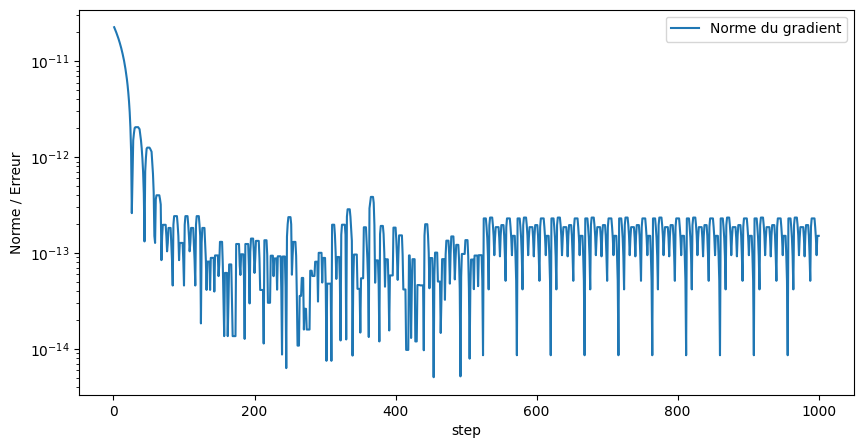

weights : [ 27.11759049 -48.68231753  73.38693443  73.20055482 -47.20477258
 -78.49742459]


In [40]:
def apprentissage(algoDesc=Algorithme_Gradient,**kwargs):
	(weights,nbsteps)=algoDesc(**kwargs)
	return(weights,nbsteps)
#sizeVector=5
#(RawData,RawC)=LireDonnees(os.path.join(os.getcwd(), "Data", "Cotations2020.csv"))
#(D,C)=CreerData(RawData,RawC,sizeVector,normalize=True)
#(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=1000, tol=1.8, learning_rate=0.02,shouldplot=True)
#(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=10000, tol=0.1, learning_rate=0.02,shouldplot=True,weights=weights)
(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=1000, tol=0.0000000000000005, learning_rate=0.00000000000001,shouldplot=True,weights=weights)
#(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=50000, tol=0.2, learning_rate=0.002,shouldplot=True,weights=weights)
#(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=50000, tol=0.2, learning_rate=0.0005,shouldplot=True,weights=weights)
#(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=50000, tol=0.2, learning_rate=0.0002,shouldplot=True,weights=weights)
#(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=50000, tol=0.2, learning_rate=0.0001,shouldplot=True,weights=weights)
#(weights,nbsteps)=apprentissage(D=D,C=C,sizeVector=sizeVector,algoDesc=Algorithme_Adam,func=Sigmoid, maxstep=50000, tol=0.2, learning_rate=0.00005,shouldplot=True,weights=weights)
print("weights :",weights)

## Construction du prédicteur

Il faut maintenant construire votre prédicteur : je vous propose le code suivant.

In [19]:
# Input: weights, les poids appris pendant l'apprentissage
#       constant, la constante apprise pendant l'apprentissage
#       v, le vecteur à partir duquel on veut prédire
# Nécessite : que l'apprentissage ait été fait, i.e. on dispose de weights et constant
# Output : le résultat de la prédiction
def Prediction(weights, v, func=Sigmoid):
    #print ("Prediction :",func(H(weights, v)))
    if func(H(weights, v))>0.5:
            return 1
    else: 
            return 0

Généralisons un peu ce prédicteur pour l'évaluer sur une base de vecteurs $\vec v$

In [20]:
# Input: weights, les poids appris pendant l'apprentissage
#       constant, la constante apprise pendant l'apprentissage
#       D, une base de données de vecteurs à partir duquel on veut prédire
# Nécessite : que l'apprentissage ait été fait, i.e. on dispose de weights et constant
# Output : Cpred, le vecteur des prédictions associées

def PredictionsOnBase(weigths,D,func=Sigmoid):
    Cpred=[]
    for index in range(len(D)):
        Cpred.append(Prediction(weights,D[index:index+1,:], func=func))
    return Cpred

## Evaluation du prédicteur sur la base d'apprentissage

Le code ci-dessous va vous permettre d'évaluer la qualité de votre prédicteur sur la base d'apprentissage, autrement dit:
- Calcul du pourcentage de bonnes classifications,
- Matrice de confusion : vous donnera la répartition des bonnes/mauvaises classifications.

In [41]:
# Pour exécuter ce code vous devez avoir au préalable exécuté l'apprentissage => on doit disposer des weights et constant
(RawData_test,RawC_test)=LireDonnees(os.path.join(os.getcwd(), "Data", "Cotations2021.csv"))
(D_test,C_test)=CreerData(RawData_test,RawC_test,sizeVector,normalize=True)
Cpred=PredictionsOnBase(weights,D_test, func=GELU)
GoodPred=0
VraiPositifs=0
FauxPositifs=0
VraiNegatifs=0
FauxNegatifs=0
NumberPositif=0
for index in range(len(C_test)):
    if (C_test[index]==1): 
        NumberPositif +=1
    if (C_test[index]==Cpred[index]):
        GoodPred+=1
    if (C_test[index]==1):
        if (Cpred[index]==1):
            VraiPositifs+=1
        else:
            FauxNegatifs+=1
    if (C_test[index]==0):
        if (Cpred[index]==1):
            FauxPositifs+=1
        else:
            VraiNegatifs+=1
print("Taux de bonnes classifications : ",100.0*GoodPred/len(C_test),"%")
print("Quand il fallait prédire 1...")
print(100.0*VraiPositifs/NumberPositif,"% du temps le prédicteur prédit 1")
print(100.0*FauxNegatifs/NumberPositif,"% du temps le prédicteur prédit 0")
print("Quand il fallait prédire 0...")
print(100.0*VraiNegatifs/(len(C_test)-NumberPositif),"% du temps le prédicteur prédit 0")
print(100.0*FauxPositifs/(len(C_test)-NumberPositif),"% du temps le prédicteur prédit 1")
print (weights)

print(Sigmoid(np.dot(weights,D_test[0,:])))

RawData size : 255
RawC size : 254
Taux de bonnes classifications :  51.80722891566265 %
Quand il fallait prédire 1...
14.049586776859504 % du temps le prédicteur prédit 1
85.9504132231405 % du temps le prédicteur prédit 0
Quand il fallait prédire 0...
87.5 % du temps le prédicteur prédit 0
12.5 % du temps le prédicteur prédit 1
[ 27.11759049 -48.68231753  73.38693443  73.20055482 -47.20477258
 -78.49742459]
0.2494506958604399
